# How to execute the PyPSA-Earth workflow?

This notebook aims to make you confident about understanding, executing and setting up PyPSA-Earth workflows.
 
This tutorial will cover:
- Snakemake
- Snakefiles
- How to create Directed Acyclic Graphs or `--dag`'s
- Different ways to execute workflows
- Wildcards

Requirements:
- Installed PyPSA-Earth (i.e. in `~/home/pypsa-earth`)
- Installed anaconda environment `(pypsa-earth)`

## Preparation

You may need to install **ipython** while being in the `pypsa-earth` environment to choose the environment in VS code/Jupyter lab. Install the ipython kernel like this:

```
(pypsa-earth).../pypsa-earth % ipython kernel install --user --name=pypsa-earth

```

Finally we need to import a package to display images.

In [1]:
from IPython import display

## Snakemake

[Snakemake](https://snakemake.readthedocs.io/en/stable/) is our workflow management tool which allows you to define and execute workflow in a flexible manner. It safes you plenty of time! As a first inspiration:
1. Open your VScode terminal in the `pypsa-earth` folder
2. Copy and rename the `config.tutorial.yaml` > `config.yaml`
3. Open the `config.yaml` and replace the `cluster: [6]` to `clusters: [5,10,20,30]`
4. Activate your pypsa-earth environment: `conda activate pypsa-earth`
5. Type the following in the terminal: 

```
snakemake --dag solve_all_networks | dot -Tpng -o workflow.png
```

You should see now a image "Directed Acyclic Graph" or short "dag" in your folder which is saved as **workflow.png** and describes the workflow that you would execute. Just image you would need to execute script by script by hand. Not impossible for the workflow below, but just imagine you have 100 or 1000 optimisation. Snakemake saves your valuable time in such situations.

Sometimes visualization with the directive above may result in an error like `'Error: <stdin>: syntax error in line 1 near 'Restricted''`. (Big thanks to Yiliao Zhou for reporting [this issue](https://github.com/pypsa-meets-africa/pypsa-africa-hackathon/issues/17)!) This error appears if the Snakemake output contains some text like solver info messages which is not supposed to be there by the graphiz visualizer. The solution is to get rid of this additional text. For example, we may cut a part of the output which is meaningful for building a workflow graph with `snakemake --dag solve_all_networks | sed -n "/digraph/,/}/p" | dot -Tpng -o workflow.png`.

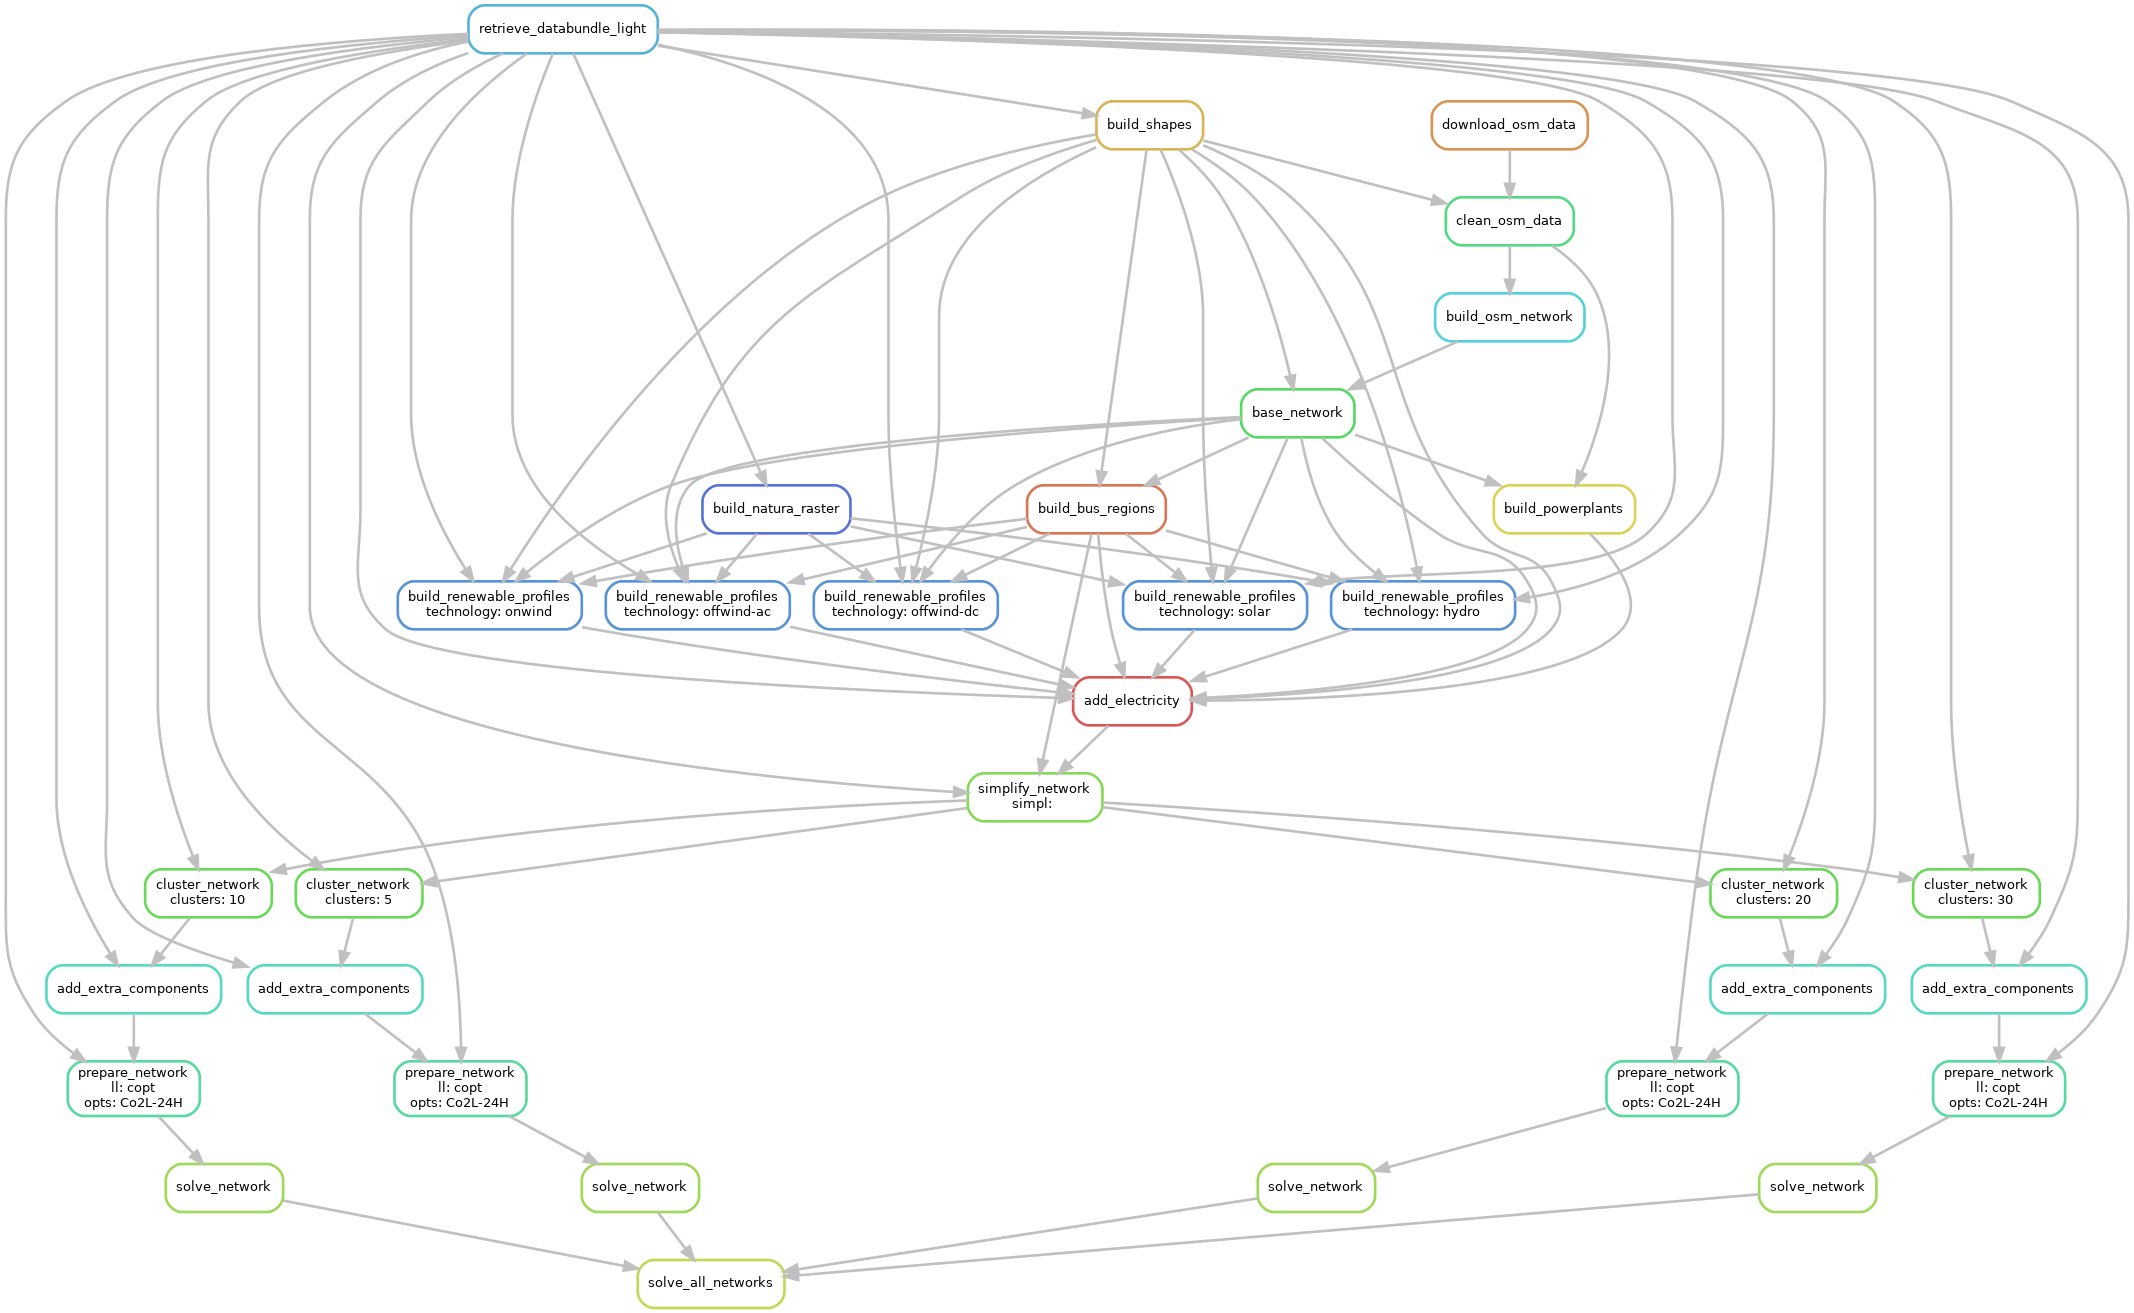

In [2]:
display.Image("./images/hackathon/workflow_example.png")

## Snakefile

All the workflows are described in the `Snakefile` which you can find in the `pypsa-earth` repository.

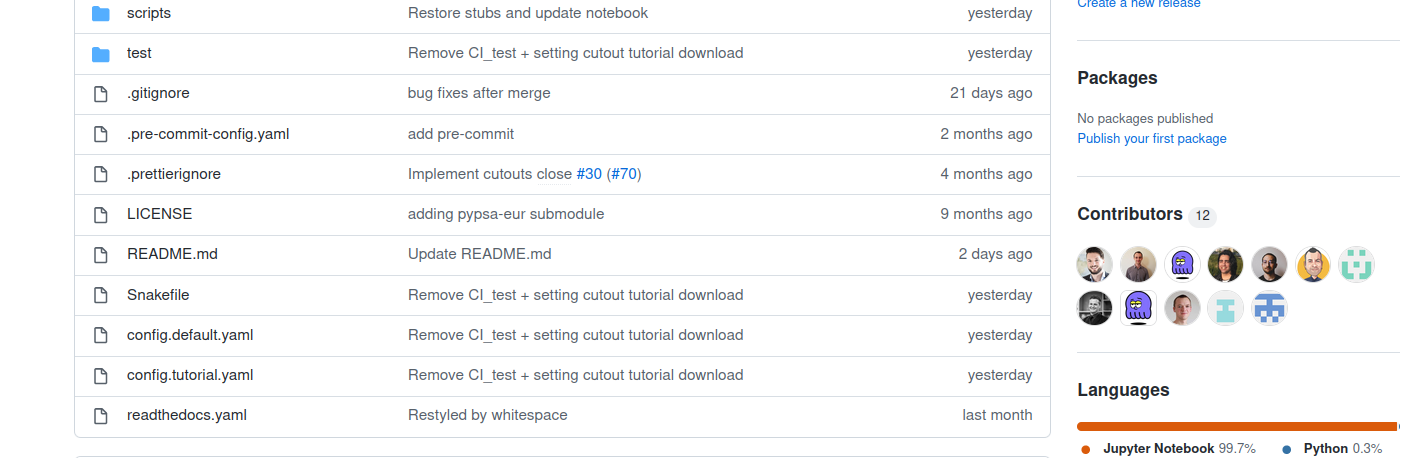

In [3]:
display.Image("./images/hackathon/snakefile_location.png")

When we open the Snakefile, we can see typically:
- **rules**, gives a workflow component a name
- **scripts**, describes what function is used from `pypsa-earth/scripts`
- **inputs**, informs what data goes into the function
- **outputs**, informs what data goes out of the function

The other features like `threads` and `resources` can be used to allow parallel thread computing/ computing management. Further, the `log` is used to document the executed function.

In case of the `rule build_shapes:`, the workflow inputs `eez` data which is [georeferenced marine data](https://www.marineregions.org/downloads.php) that we need in the `scripts/build_shapes.py` to allocate areas of the sea to specific countries. As output the rule creates:
- country shapes
- offshore shapes
- general region shape
- regional to subregional zones or [gadm_shapes](https://gadm.org/)


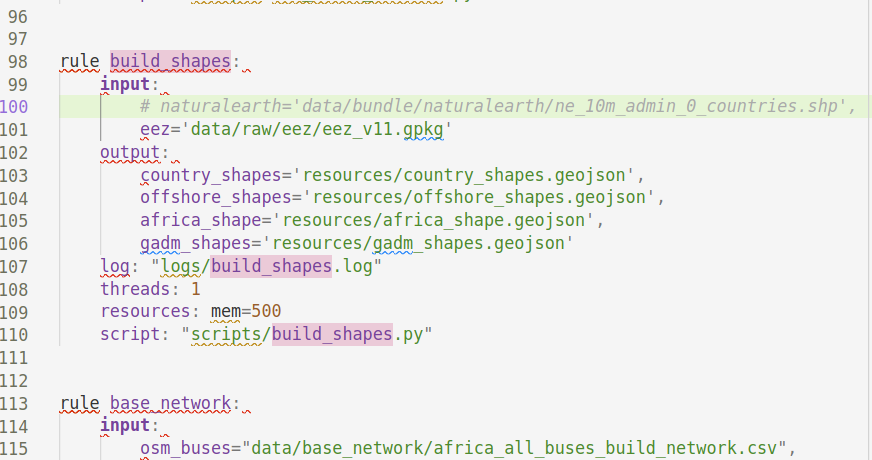

In [4]:
display.Image("./images/hackathon/build_shapes_rule.png")

## Ways to execute workflows
There are three different ways to execute workflows. Compare the below examples with the above build_shapes rule:
1. execute on the output `snakemake --cores 1 resources/country_shapes.geojson --dryrun`
2. execute on the rule `snakemake -j 1 build_shapes -n` (Note, -j equals --cores, and -n equals --dryrun)
3. execute on solve_all_networks (runs all rules -> defined in `Snakefile`)

Before starting an execution, it is always wise to start with a dry-run. This will not create any files or execute any functions, but it helps understanding what will happen if you do so. To execute a rule simply leave out the `-n` or `--dryrun`.

Let's see what the `--dag` says before after the execution:

```
snakemake --dag build_shapes | dot -Tpng -o build_shapes_dag.png
```

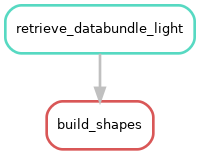

In [5]:
# Before Snakemake was executed
display.Image("./images/hackathon/build_shapes_dag_prerun.png")

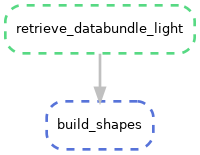

In [6]:
# After Snakemake was executed
display.Image("./images/hackathon/build_shapes_dag_postrun.png")

Seems alright. The build_shapes rule only requires inputs form the retrieve_data_bundle rule. Once the rule is executed it becomes dashes, revealing that there is already data available.

### What are the {} in the outputs?

Some rules such the `rule cluster_network` have this curly brackets in the inputs and outputs. These are called **wildcards**. One example:
```
network='networks/elec_s{simpl}_{clusters}.nc'
```

In PyPSA-Earth we implemented **wildcards** as they exist in PyPSA-Eur. Checking their [documentation](https://pypsa-eur.readthedocs.io/en/latest/wildcards.html#wildcards) out, one can see that we can remove `{simpl}` as preclustering is not necessary and replace `{cluster}` by any number of buses which the whole network should be aggregated towards.

For instance:
- `snakemake --cores 1 networks/elec_s_10.nc -n` will start a dry run for a network clustered to 10 nodes
- `snakemake --cores 1 networks/elec_s_100.nc -n` will start a dry run for a network clustered to 100 nodes

Note that these wildcards are what enables to run thousands of simulations.

# Try it yourself.

**Find the below rule** in the `Snakefile` and create a dag:
- `rule build_powerplants`

**Find the below rules** and execute a dry-run from the 1) rule and 2) the output file:
- `rule download_osm_data:`
- `rule cluster_network:`

**Find the rules with the below functions** and execute a dry-run from the 1) rule and 2) the output file:
- `scripts/add_electricity.py`
- `scripts/prepare_network.py`

**Make a dry-run with the following output:**
Use the [documentation](https://pypsa-eur.readthedocs.io/en/latest/wildcards.html#wildcards) to find values to replace the wildcards:
```
output: "results/networks/elec_s{simpl}_{clusters}_ec_l{ll}_{opts}.nc"
```

**Really cool. Modify the config.yaml and create a --dag:**

Insert the following parameters in the `config.yaml`
```
scenario:
  simpl: ['']
  ll: ['copt']
  clusters: [5,10,20,30]
  opts: [Co2L0.0-1H, Co2L0.0-3H, Co2L0.0-6H, , Co2L0.0-12H]
```

Create a `--dag` with the solve_all_network rule. Can you explain from the `--dag` what will happen?

## snakemake --help
There are some good execution tools which you might need. Read and test them if possible.
- --forcerun
- --forceall
- --delete-all-output
- --report
- --debug

To see the full list of snakemake options type `snakemake --help` in you terminal


## Creating a new workflow rule

Now that you know how to execute workflows, what about creating one?

Just think first **what you want to achieve (=function)?**. Then simply add what you **expect as input and output**. This helps you designing multiple rules before even starting to code, supports organising your thoughts and finally improves the rule integration into a larger workflow. Maybe you can even simplify or improve our existing snakemake rules? 

A good length of a digestible python script is around 300-500 lines.

```
rule YOUR_RULE:
    input:
        <Expected_inputs_required_by_the_function>=''
    output:
        <Expected_outputs_from_the_function>=''
    log: "logs/YOUR_RULE.log"
    threads: 1
    resources: mem=1000
    script: "scripts/<YOUR_FUNCTION>.py"
```


# Key points:
- You understand the purpose of the Snakefile (rule, input, output, function)
- You can create `--dag`'s (`snakemake --dag solve_all_networks | dot -Tpng -o workflow.png`)
- You can execute rules in 3 different ways (output based, rule based or by running all workflows)
- You understand how wildcards are used and executed
- You know how to create a new workflow